## PyTorch Computer Vision
* [`torchvision datasets`](https://pytorch.org/vision/stable/datasets.html)
* [`torchvision models`](https://pytorch.org/vision/stable/search.html?q=torchvision+models&check_keywords=yes&area=default#)

In [ ]:
# Import Torch
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import marplotlib
import matplotlib.pyplot as plt

In [ ]:
from torchvision import datasets, transforms

# Define train and test transforms
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),            # Data augmentation
    transforms.RandomHorizontalFlip(),               # More augmentation
    transforms.ToTensor(),                           # Convert to tensor
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])  # Normalize CIFAR-10
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

In [ ]:
train_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),#train_transform,
    target_transform= None
)

test_data = datasets.CIFAR10(
    root = "data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [ ]:
len(train_data), len(test_data)

(50000, 10000)

In [ ]:
class_names = train_data.classes

In [ ]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
image, label = train_data[torch.randint(0 , len(train_data), size=[1])]

In [ ]:
image.shape, label

(torch.Size([3, 32, 32]), 2)

In [ ]:
image = image.permute(1,2,0)
image.shape

torch.Size([32, 32, 3])

### Importing and visualization of data:

airplane


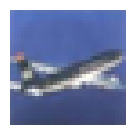

In [ ]:
image, label = train_data[torch.randint(0 , len(train_data), size=[1])]
image = image.permute(1,2,0)

plt.figure(figsize=(1.5, 1.5))
plt.imshow(image)
plt.axis(False)

print(class_names[label])

Examples of Training Data:

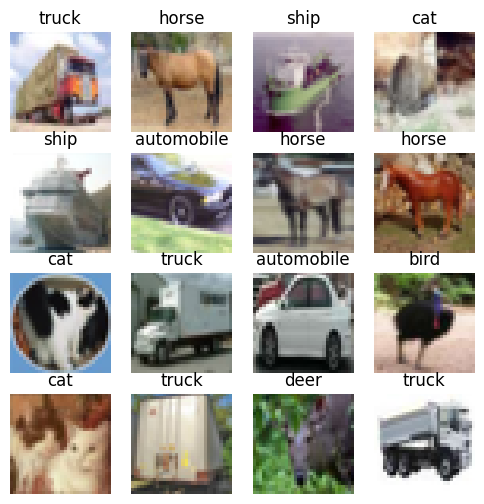

In [ ]:
torch.manual_seed(69420)
fig = plt.figure(figsize=(6,6))
rows , columns =4, 4
for i in range(1, rows*columns + 1):
    random_idx = torch.randint(0, len(train_data), size=[1])
    img, label = train_data[random_idx]
    img = img.permute(1,2,0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis(False)

Flipping the labels of the training data:

In [ ]:
import numpy as np
import random

def inject_symmetric_noise(dataset, noise_rate=0.4, num_classes=10):
    noisy_labels = np.array(dataset.targets)
    n_samples = len(noisy_labels)
    n_noisy = int(noise_rate * n_samples)

    noisy_indices = np.random.choice(n_samples, n_noisy, replace=False)

    for idx in noisy_indices:
        original_label = noisy_labels[idx]
        noisy_label = random.choice([i for i in range(num_classes) if i != original_label])
        noisy_labels[idx] = noisy_label

    dataset.targets = noisy_labels.tolist()

Examples of mislabeled data:

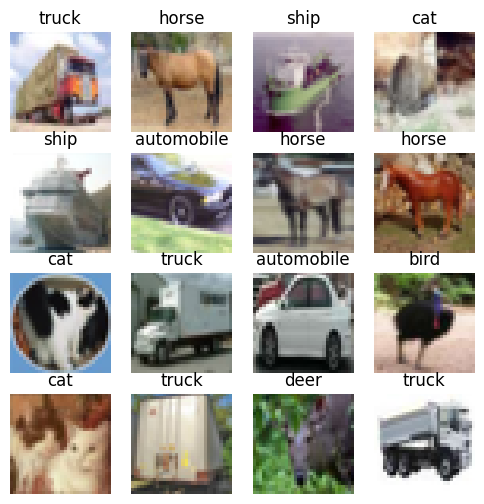

In [ ]:
torch.manual_seed(69420)
fig = plt.figure(figsize=(6,6))
rows , columns =4, 4
for i in range(1, rows*columns + 1):
    random_idx = torch.randint(0, len(train_data), size=[1])
    img, label = train_data[random_idx]
    img = img.permute(1,2,0)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis(False)

Let us now divide our data into mini_batches for efficient computing

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [ ]:
len(train_dataloader), len(test_dataloader)

(1563, 313)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

### The following classes are an implementation of `ResNet-18` style architechture so that I can get good accuracy on the data

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # CIFAR-10-specific initial conv (smaller kernel, no maxpool)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.layer1 = self._make_layer(block, 64,  layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # global avg pooling
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None

        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion

        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)  # 32x32
        x = self.layer2(x)  # 16x16
        x = self.layer3(x)  # 8x8
        x = self.layer4(x)  # 4x4

        x = self.avgpool(x)  # 1x1
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
def resnet18_cifar10():
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)

In [ ]:
model = resnet18_cifar10()

### We will now create our own NCE loss and import optimizers and other loss functions

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NormalizedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(NormalizedCrossEntropyLoss, self).__init__()

    def forward(self, logits, targets):
        # Normalize logits (along class dimension)
        norm_logits = F.log_softmax(logits, dim=1)  # log(softmax) = log-probabilities
        norm_logits = norm_logits - norm_logits.logsumexp(dim=1, keepdim=True)  # double normalization

        # Negative log-likelihood loss
        loss = F.nll_loss(norm_logits, targets)
        return loss

In [ ]:
class APLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super().__init__()
        self.alpha = alpha
        self.ce = nn.CrossEntropyLoss()
        self.mae = nn.L1Loss()

    def forward(self, logits, targets):
        # CE expects class indices
        ce_loss = self.ce(logits, targets)

        # Convert class indices to one-hot for L1/MAE
        one_hot = F.one_hot(targets, num_classes=logits.size(1)).float()
        probs = F.softmax(logits, dim=1)

        mae_loss = self.mae(probs, one_hot)

        return self.alpha * ce_loss + (1 - self.alpha) * mae_loss

In [ ]:
CE_loss = nn.CrossEntropyLoss()
NCE_loss = NormalizedCrossEntropyLoss()
APL_loss = APLoss(alpha=0.5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)#, momentum=0.9, weight_decay=5e-4)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)

In [ ]:
device=("cuda")

# I am now going to define a training and testing loop now for reusability for all 3 kinds of loss

In [ ]:
training_loss=[]
training_acc=[]

testing_acc=[]
testing_loss=[]

train_loss_ce=[]
train_acc_ce=[]
test_acc_ce=[]

train_loss_nce=[]
train_acc_nce=[]
test_acc_nce=[]

train_loss_apl=[]
train_acc_apl=[]
test_acc_apl=[]

epoch_count=[]

In [ ]:
train_loss_apl=[]
train_acc_apl=[]
test_acc_apl=[]

In [ ]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device=device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    train_loss_apl.append(train_loss)
    train_acc_apl.append(train_acc)

    epoch_count.append(epoch)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader, model, loss_fn, accuracy_fn, device=device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)

            test_loss += loss_fn(test_pred, y).item()
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    test_acc_apl.append(test_acc)

    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Defining functions which can be used to plot graphs:

In [ ]:
def plot_loss(training_loss, testing_loss, epoch_count):
    plt.plot(epoch_count, training_loss, label="Training Loss", c="r")
    plt.plot(epoch_count, testing_loss, label="Testing Loss", c="b")
    plt.title("Training and Testing Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

This github repo is from the youtuber **Daniel Bourke**,
I have used the calculate accuracy function from this.

[Github Repo raw](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py)

In [ ]:
from os.path import isfile
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_functions.py...")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download...


I also imported a timer to check how much the code benefitted from changing the device to CUDA

In [ ]:
from timeit import default_timer as timer
def train_time(start: float,
               end: float,
               device: torch.device = None):
    total_time = end -start
    print(f"Train time on {device}: {total_time: .3f} seconds")
    return total_time

### Let's First train the model on data without any label noise

In [ ]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

start_time = timer()
epochs = 23

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=CE_loss,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device = device)
    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=CE_loss,
              accuracy_fn=accuracy_fn,
              device=device)
end_time= timer()
time = train_time(start=start_time, end= end_time, device = device)

  0%|          | 0/23 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 1.21494 | Train accuracy: 56.13%
Test loss: 0.95627 | Test accuracy: 66.59%

Epoch: 1
-----
Train loss: 0.76976 | Train accuracy: 72.94%
Test loss: 0.89023 | Test accuracy: 69.71%

Epoch: 2
-----
Train loss: 0.55061 | Train accuracy: 80.89%
Test loss: 0.78704 | Test accuracy: 74.04%

Epoch: 3
-----
Train loss: 0.40407 | Train accuracy: 85.83%
Test loss: 0.61596 | Test accuracy: 79.52%

Epoch: 4
-----
Train loss: 0.27076 | Train accuracy: 90.60%
Test loss: 0.69774 | Test accuracy: 77.62%

Epoch: 5
-----
Train loss: 0.18449 | Train accuracy: 93.57%
Test loss: 0.73625 | Test accuracy: 78.46%

Epoch: 6
-----
Train loss: 0.12400 | Train accuracy: 95.81%
Test loss: 0.82926 | Test accuracy: 77.84%

Epoch: 7
-----
Train loss: 0.08816 | Train accuracy: 97.09%
Test loss: 0.70974 | Test accuracy: 80.77%

Epoch: 8
-----
Train loss: 0.05853 | Train accuracy: 98.16%
Test loss: 0.80575 | Test accuracy: 79.87%

Epoch: 9
-----
Train loss: 0.04342 | Train accuracy: 98.62%
Test

In [ ]:
epoch_count = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]
def plot_accuracy(epoch_count, training_acc, testing_acc):
    plt.plot(epoch_count, testing_acc, c="b", label="Testing Accuracy")
    plt.plot(epoch_count, training_acc, c="r", label="Training Accuracy")
    plt.title("Training and Testing Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

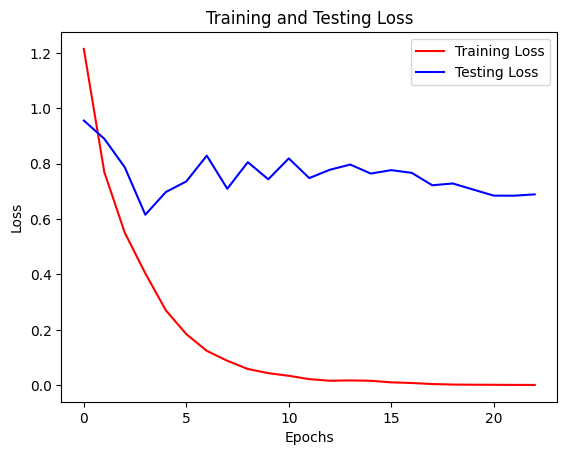

In [ ]:
plot_loss(epoch_count=epoch_count, training_loss=training_loss, testing_loss=testing_loss)

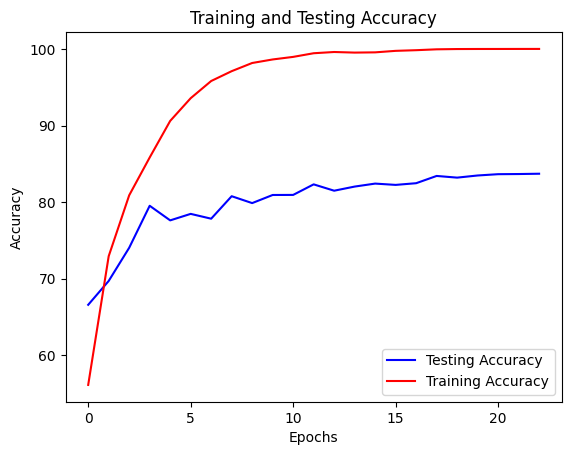

In [ ]:
plot_accuracy(epoch_count=epoch_count, training_acc=training_acc, testing_acc=testing_acc)

### Now let's start training on noisy data

In [ ]:
inject_symmetric_noise(train_data, noise_rate=0.5)

**`CE_LOSS`**

In [ ]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

start_time = timer()
epochs = 8

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=CE_loss,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device = device)
    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=CE_loss,
              accuracy_fn=accuracy_fn,
              device=device)
end_time= timer()
time = train_time(start=start_time, end= end_time, device = device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 2.32052 | Train accuracy: 12.64%
Test loss: 2.08858 | Test accuracy: 28.63%

Epoch: 1
-----
Train loss: 2.28631 | Train accuracy: 15.16%
Test loss: 2.04046 | Test accuracy: 36.18%

Epoch: 2
-----
Train loss: 2.24849 | Train accuracy: 17.74%
Test loss: 2.06282 | Test accuracy: 27.08%

Epoch: 3
-----
Train loss: 2.19874 | Train accuracy: 20.77%
Test loss: 2.00817 | Test accuracy: 33.94%

Epoch: 4
-----
Train loss: 2.12089 | Train accuracy: 24.37%
Test loss: 2.04584 | Test accuracy: 29.43%

Epoch: 5
-----
Train loss: 1.99172 | Train accuracy: 30.29%
Test loss: 2.20514 | Test accuracy: 22.82%

Epoch: 6
-----
Train loss: 1.80199 | Train accuracy: 37.75%
Test loss: 2.24346 | Test accuracy: 24.48%

Epoch: 7
-----
Train loss: 1.54428 | Train accuracy: 47.02%
Test loss: 2.54054 | Test accuracy: 21.08%

Train time on cuda:  420.427 seconds


**`NCE_LOSS`**

In [ ]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

start_time = timer()
epochs = 8

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=NCE_loss,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device = device)
    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=NCE_loss,
              accuracy_fn=accuracy_fn,
              device=device)
end_time= timer()
time = train_time(start=start_time, end= end_time, device = device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 2.22795 | Train accuracy: 18.90%
Test loss: 1.90796 | Test accuracy: 40.29%

Epoch: 1
-----
Train loss: 2.15765 | Train accuracy: 24.79%
Test loss: 1.75321 | Test accuracy: 45.44%

Epoch: 2
-----
Train loss: 2.11386 | Train accuracy: 27.68%
Test loss: 1.74385 | Test accuracy: 47.23%

Epoch: 3
-----
Train loss: 2.07179 | Train accuracy: 29.94%
Test loss: 1.68381 | Test accuracy: 49.76%

Epoch: 4
-----
Train loss: 2.02329 | Train accuracy: 32.39%
Test loss: 1.68441 | Test accuracy: 49.05%

Epoch: 5
-----
Train loss: 1.96177 | Train accuracy: 34.64%
Test loss: 1.62161 | Test accuracy: 50.28%

Epoch: 6
-----
Train loss: 1.88656 | Train accuracy: 37.23%
Test loss: 1.61222 | Test accuracy: 47.97%

Epoch: 7
-----
Train loss: 1.78796 | Train accuracy: 40.69%
Test loss: 1.75106 | Test accuracy: 41.37%

Train time on cuda:  404.645 seconds


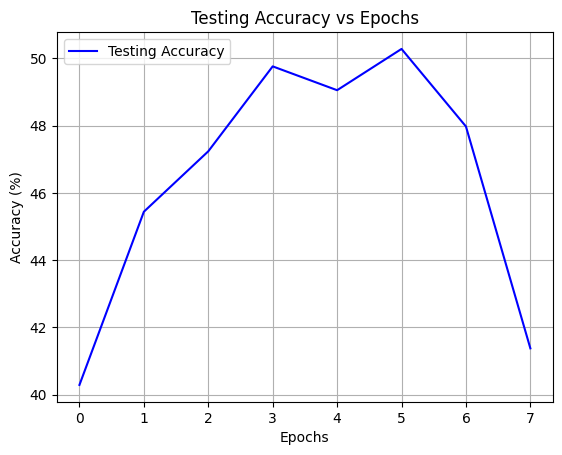

In [ ]:
e_c = [0,1,2,3,4,5,6,7]
test_acc_nce
plt.plot(e_c, test_acc_nce, c="b", label="Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Testing Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
idx = np.argmax(test_acc_nce)
print(f"For NCE")
print(f"Train loss: {train_loss_nce[idx]} | Train acc: {train_acc_nce[idx]}% | Test acc: {test_acc_nce[idx]}%")

For NCE
Train loss: 1.9617698362677507 | Train acc: 34.644913627639156% | Test acc: 50.27955271565495%


**`APL_loss`**

In [ ]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

start_time = timer()
epochs = 8

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=APL_loss,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device = device)
    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=APL_loss,
              accuracy_fn=accuracy_fn,
              device=device)
end_time= timer()
time = train_time(start=start_time, end= end_time, device = device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 1.21277 | Train accuracy: 17.13%
Test loss: 1.08135 | Test accuracy: 34.00%

Epoch: 1
-----
Train loss: 1.18077 | Train accuracy: 22.60%
Test loss: 1.01766 | Test accuracy: 41.17%

Epoch: 2
-----
Train loss: 1.16047 | Train accuracy: 25.44%
Test loss: 0.98479 | Test accuracy: 43.82%

Epoch: 3
-----
Train loss: 1.14448 | Train accuracy: 27.27%
Test loss: 0.95550 | Test accuracy: 46.40%

Epoch: 4
-----
Train loss: 1.12924 | Train accuracy: 28.96%
Test loss: 0.93314 | Test accuracy: 46.96%

Epoch: 5
-----
Train loss: 1.11276 | Train accuracy: 30.60%
Test loss: 0.92494 | Test accuracy: 48.36%

Epoch: 6
-----
Train loss: 1.09416 | Train accuracy: 32.21%
Test loss: 0.91519 | Test accuracy: 49.32%

Epoch: 7
-----
Train loss: 1.07233 | Train accuracy: 33.77%
Test loss: 0.91678 | Test accuracy: 48.67%

Train time on cuda:  403.754 seconds


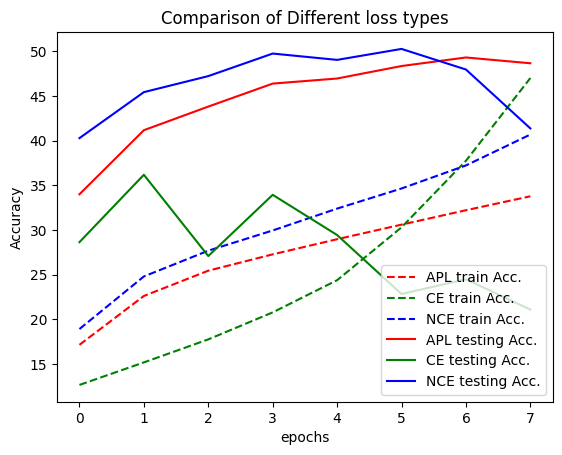

In [ ]:
epoch_count = [0,1,2,3,4,5,6,7]
plt.title("Comparison of Different loss types")
plt.plot(epoch_count, train_acc_apl, linestyle="--", color="r", label="APL train Acc.")
plt.plot(epoch_count, train_acc_ce, linestyle="--", color="g", label="CE train Acc.")
plt.plot(epoch_count, train_acc_nce, linestyle="--", color="b", label="NCE train Acc.")
plt.plot(epoch_count, test_acc_apl, color="r", label="APL testing Acc.")
plt.plot(epoch_count, test_acc_ce, color="g", label="CE testing Acc.")
plt.plot(epoch_count, test_acc_nce, color="b", label="NCE testing Acc.")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import nbformat

input_path = "/content/drive/My Drive/help/03_final_method_PyTorch.ipynb"
output_path = "/content/drive/My Drive/help/fixed_03_final_method_PyTorch.ipynb"

# Load notebook
with open(input_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# Fix metadata.widgets
widgets_meta = nb.metadata.get("widgets", {})
if "state" not in widgets_meta:
    widgets_meta["state"] = {}
if "version" not in widgets_meta:
    widgets_meta["version"] = "1.1.1"

nb.metadata["widgets"] = widgets_meta

# Save fixed notebook
with open(output_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("✅ Notebook fixed and saved at:", output_path)


✅ Notebook fixed and saved at: /content/drive/My Drive/help/fixed_03_final_method_PyTorch.ipynb
